# HW1 – Frequent Patterns

**DUE: Mar 4, 2024 (Monday)**  

Pair Programming: Optional, but highly encouraged

Name(s): Harrison Halesworth and Junior Weil
Class: CSCI 349 - Intro to Data Mining  
Section: 01-11am
Semester: Spring 2024
Instructors: Brian King, Joshua Stough

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
from itertools import combinations
from datetime import datetime
from scipy.stats import zscore
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Phase 1

In [2]:
# IDs (Movie ID as index)
ids = pd.read_csv("C:\\Users\\hhale\\csci349_2024sp\\data\\ml-latest-small\\links.csv", index_col=0)

In [3]:
# Movies (Movie ID as index)
movies = pd.read_csv("C:\\Users\\hhale\\csci349_2024sp\\data\\ml-latest-small\\movies.csv", index_col=0)

Distribution of the number of ratings by movie :
title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
                                            ... 
King Solomon's Mines (1950)                    1
King Solomon's Mines (1937)                    1
King Ralph (1991)                              1
King Kong Lives (1986)                         1
À nous la liberté (Freedom for Us) (1931)      1
Length: 9719, dtype: int64



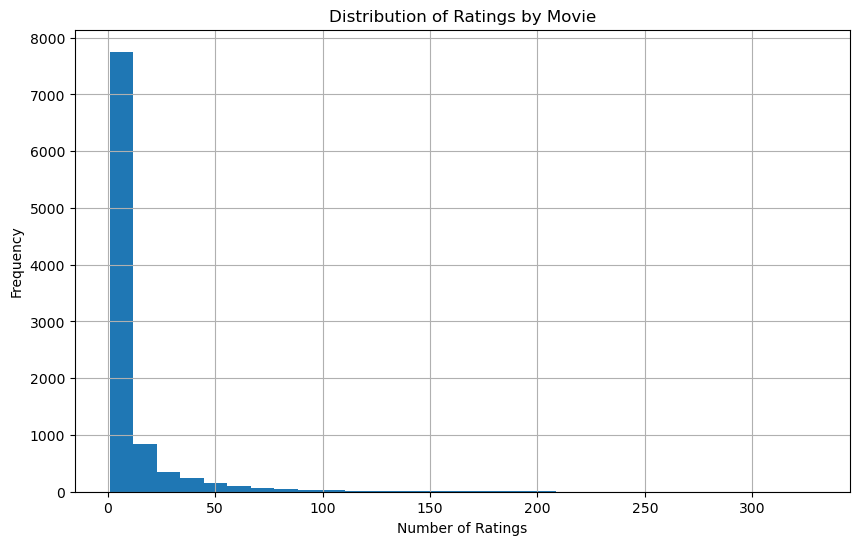

In [4]:
# Ratings (User ID as index)
ratings = pd.read_csv("C:\\Users\\hhale\\csci349_2024sp\\data\\ml-latest-small\\ratings.csv", index_col=0)
ratings["timestamp"] = ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x))

# What is the distribution of the number of ratings by movie? What about by user?
# By movie
combined = pd.merge(ratings, movies, on="movieId")
ratings_per_movie = combined.groupby("title").size()
sorted_per_movie = ratings_per_movie.sort_values(ascending=False)
print("Distribution of the number of ratings by movie :\n" + str(sorted_per_movie) + "\n")

## Plot
plt.figure(figsize=(10, 6))
ratings_per_movie.hist(bins=30)
plt.title("Distribution of Ratings by Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

Distribution of the number of ratings by user :
userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Length: 610, dtype: int64



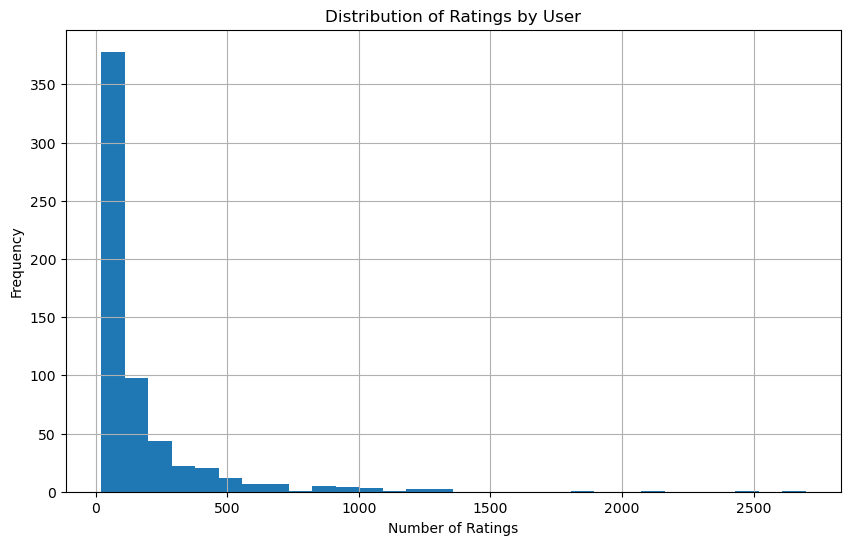

In [5]:
# By user
ratings_per_user = ratings.groupby("userId").size()
sorted_per_user = ratings_per_user.sort_values(ascending=False)
print("Distribution of the number of ratings by user :\n" + str(sorted_per_user) + "\n")

## Plot
plt.figure(figsize=(10, 6))
ratings_per_user.hist(bins=30)
plt.title("Distribution of Ratings by User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

The movies with the most ratings are : 
title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
dtype: int64

The movies with the least ratings are : 
title
King Solomon's Mines (1950)                  1
King Solomon's Mines (1937)                  1
King Ralph (1991)                            1
King Kong Lives (1986)                       1
À nous la liberté (Freedom for Us) (1931)    1
dtype: int64

Qualified movies with the highest average ratings : 
title
Streetcar Named Desire, A (1951)                 4.475000
Shawshank Redemption, The (1994)                 4.429022
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)    4.333333
Philadelphia Story, The (1940)                   4.310345
Lawrence of Arabia (1962)                        4.300000
Name: rating, dtype: float64

Qualified movies with the lowest average ratings : 
title
Inspect

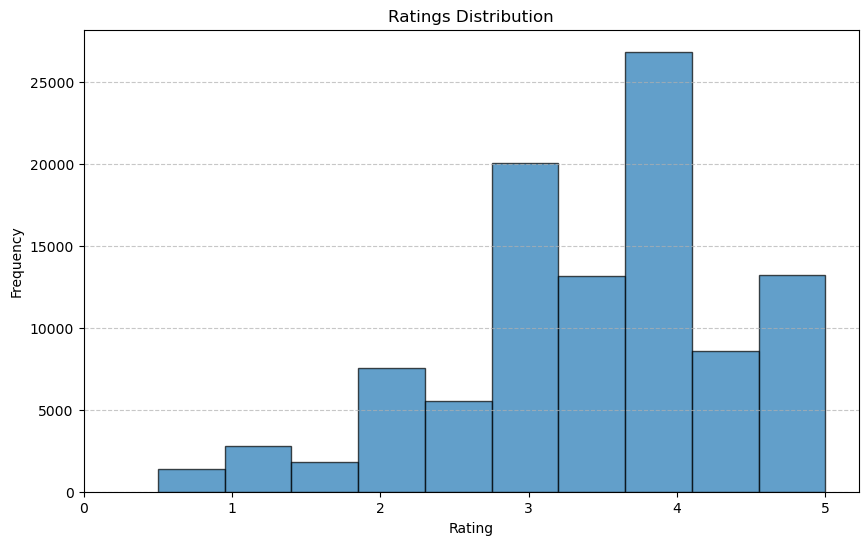

In [6]:
# What movies have the most ratings? The least?
print("The movies with the most ratings are : \n" + str(sorted_per_movie.head(5)) + "\n")
print("The movies with the least ratings are : \n" + str(sorted_per_movie.tail(5)) + "\n")

ratings_with_names = pd.merge(ratings, movies, left_on="movieId", right_index=True)
# What movies have the highest ratings? Or, the lowest ratings?
# By mean rating (minimum of 20 reviews!)
ratings_counts_per_movie = ratings_with_names.groupby("title").size()
qualified = ratings_counts_per_movie[ratings_counts_per_movie >= 20].index
mean_ratings_per_movie = ratings_with_names[ratings_with_names["title"].isin(qualified)].groupby("title")["rating"].mean()
highest_rated_qualified_movies = mean_ratings_per_movie.sort_values(ascending=False)
print("Qualified movies with the highest average ratings : \n" + str(highest_rated_qualified_movies.head()) + "\n")
print("Qualified movies with the lowest average ratings : \n" + str(highest_rated_qualified_movies.tail()) + "\n")

## Plot
plt.figure(figsize=(10, 6))
plt.hist(ratings['rating'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(0, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Number of movies watched per user : 
userId
414    2698
599    2478
474    2108
448    1864
274    1346
dtype: int64


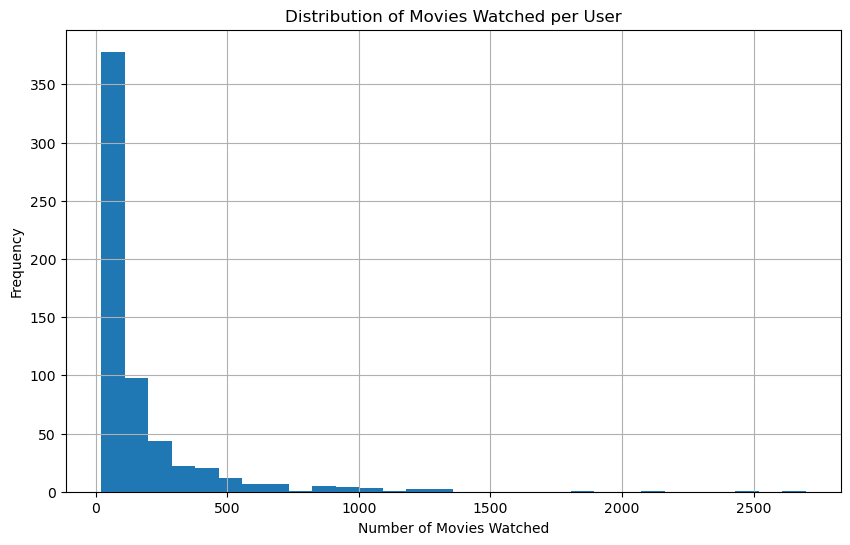

In [7]:
# What is the distribution of the number of movies watched per user?
movies_watched_per_user = ratings.groupby("userId").size().sort_values(ascending=False)
print("Number of movies watched per user : \n" + str(movies_watched_per_user.head()))

## Plot
plt.figure(figsize=(10, 6))
movies_watched_per_user.hist(bins=30)
plt.title("Distribution of Movies Watched per User")
plt.xlabel("Number of Movies Watched")
plt.ylabel("Frequency")
plt.show()

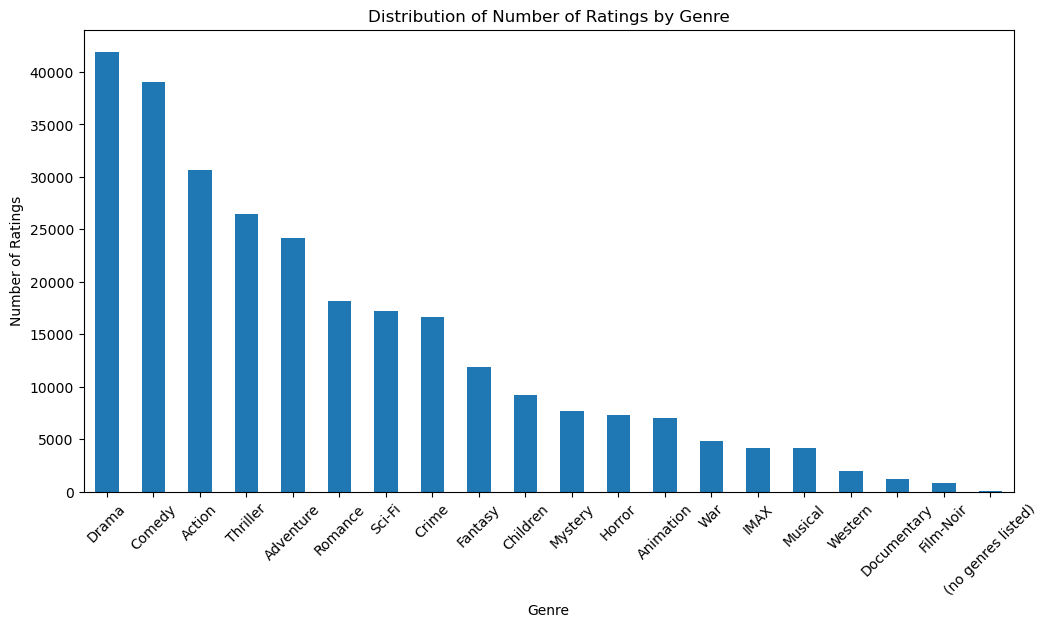

In [8]:
# What is the distribution of the number of ratings by genre? 
ratings_with_genres = pd.merge(ratings, movies, on="movieId")
ratings_with_genres["genres"] = ratings_with_genres["genres"].str.split('|')
ratings_with_genres = ratings_with_genres.explode("genres")
ratings_per_genre = ratings_with_genres.groupby("genres").size()

## Plot
plt.figure(figsize=(12, 6))
ratings_per_genre.sort_values(ascending=False).plot(kind='bar')
plt.title("Distribution of Number of Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.show()

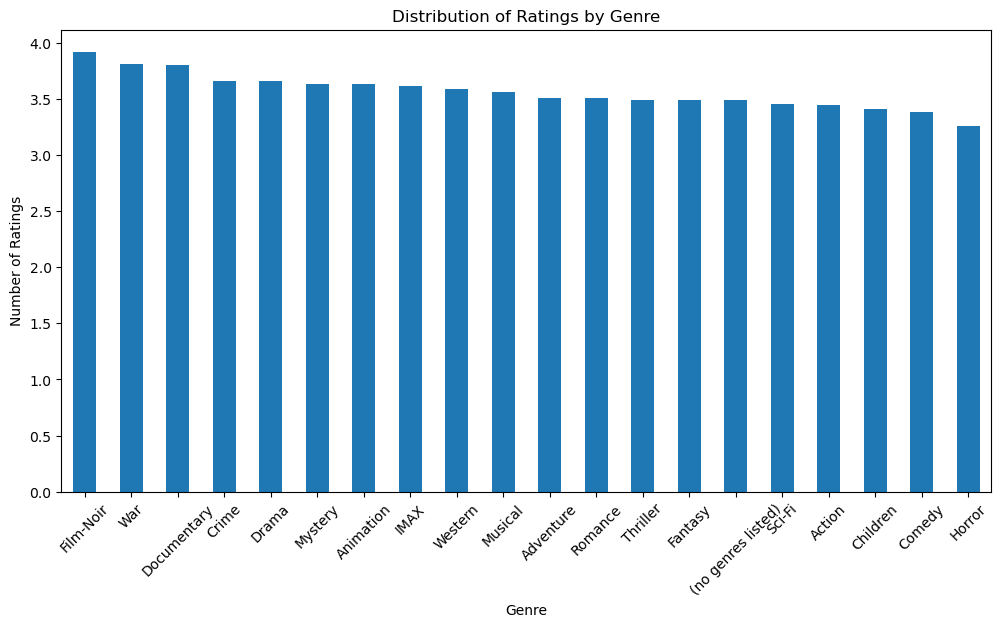

In [9]:
# What is the distribution of the ratings by genre?
average_ratings_per_genre = ratings_with_genres.groupby('genres')['rating'].mean()

## Plot
plt.figure(figsize=(12, 6))
average_ratings_per_genre.sort_values(ascending=False).plot(kind='bar')
plt.title("Distribution of Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Tags (User ID as index)
tags = pd.read_csv("C:\\Users\\hhale\\csci349_2024sp\\data\\ml-latest-small\\tags.csv", index_col=0)
tags["timestamp"] = tags["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x))
tags_with_names = pd.merge(tags, movies, left_on="movieId", right_index=True).drop(columns="movieId")

# Phase 2

In [11]:
ratings_with_names = pd.merge(ratings, movies, left_on="movieId", right_index=True)
transactions = pd.DataFrame(ratings_with_names.groupby(ratings_with_names.index)['title'].apply(list))
transactions.head()

,title
userId,
1,"[Toy Story (1995), Grumpier Old Men (1995), He..."
2,"[Tommy Boy (1995), Gladiator (2000), Shawshank..."
3,"[Schindler's List (1993), Highlander (1986), C..."
4,"[Seven (a.k.a. Se7en) (1995), Ed Wood (1994), ..."
5,"[Toy Story (1995), Usual Suspects, The (1995),..."


In [12]:
# output the top 20 most frequent patterns
encoder = TransactionEncoder()
transformed = encoder.fit(transactions["title"]).transform(transactions["title"])
transformed_df = pd.DataFrame(transformed, columns=encoder.columns_)
frequent_itemsets = apriori(transformed_df, min_support=0.10, use_colnames=True)
frequent_itemsets_sorted = frequent_itemsets.sort_values(by="support", ascending=False)
print("The top 20 most frequent patterns are : \n" + str(frequent_itemsets_sorted.head(20)) + "\n")

The top 20 most frequent patterns are : 
       support                                           itemsets
115   0.539344                              (Forrest Gump (1994))
258   0.519672                 (Shawshank Redemption, The (1994))
233   0.503279                              (Pulp Fiction (1994))
264   0.457377                 (Silence of the Lambs, The (1991))
193   0.455738                               (Matrix, The (1999))
285   0.411475        (Star Wars: Episode IV - A New Hope (1977))
167   0.390164                             (Jurassic Park (1993))
51    0.388525                                (Braveheart (1995))
2913  0.378689  (Forrest Gump (1994), Shawshank Redemption, Th...
2900  0.377049         (Pulp Fiction (1994), Forrest Gump (1994))
293   0.367213                (Terminator 2: Judgment Day (1991))
4834  0.363934  (Pulp Fiction (1994), Shawshank Redemption, Th...
251   0.360656                          (Schindler's List (1993))
111   0.357377                     

In [13]:
rules = association_rules(frequent_itemsets)
strong_rules = rules.sort_values(by=["antecedent support","consequent support","confidence","lift"], 
                                 ascending=False).head(10)
strong_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
155,(Jurassic Park (1993)),(Forrest Gump (1994)),0.390164,0.539344,0.324590,0.831933,1.542489,0.114157,2.740902,0.576708
11107,"(Pulp Fiction (1994), Shawshank Redemption, Th...",(Forrest Gump (1994)),0.363934,0.539344,0.293443,0.806306,1.494975,0.097157,2.378269,0.520532
126,(Fight Club (1999)),"(Matrix, The (1999))",0.357377,0.455738,0.295082,0.825688,1.811762,0.132212,3.122347,0.697222
324,(Star Wars: Episode V - The Empire Strikes Bac...,"(Matrix, The (1999))",0.345902,0.455738,0.283607,0.819905,1.799073,0.125966,3.022088,0.679039
373,(Star Wars: Episode V - The Empire Strikes Bac...,(Star Wars: Episode IV - A New Hope (1977)),0.345902,0.411475,0.311475,0.900474,2.188403,0.169145,5.913271,0.830220
350,(Seven (a.k.a. Se7en) (1995)),(Pulp Fiction (1994)),0.332787,0.503279,0.285246,0.857143,1.703118,0.117761,3.477049,0.618755
19,(Apollo 13 (1995)),(Forrest Gump (1994)),0.329508,0.539344,0.270492,0.820896,1.522025,0.092773,2.571995,0.511536
18025,"(Silence of the Lambs, The (1991), Shawshank R...",(Pulp Fiction (1994)),0.326230,0.503279,0.270492,0.829146,1.647488,0.106307,2.907281,0.583308
11113,"(Silence of the Lambs, The (1991), Forrest Gum...",(Pulp Fiction (1994)),0.326230,0.503279,0.268852,0.824121,1.637503,0.104668,2.824215,0.577814
262,(Lord of the Rings: The Fellowship of the Ring...,"(Lord of the Rings: The Two Towers, The (2002))",0.324590,0.308197,0.272131,0.838384,2.720288,0.172094,4.280533,0.936308


In [14]:
i=1
for index, row in strong_rules.iterrows():
    antecedents = row["antecedents"]
    consequents = row["consequents"]
    antecedents = list(antecedents)
    consequents = list(consequents)
    
    # Print the association rule in the specified format
    print(str(i) + ".) " + f"{antecedents} -> {consequents}")
    i+=1

1.) ['Jurassic Park (1993)'] -> ['Forrest Gump (1994)']
2.) ['Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)'] -> ['Forrest Gump (1994)']
3.) ['Fight Club (1999)'] -> ['Matrix, The (1999)']
4.) ['Star Wars: Episode V - The Empire Strikes Back (1980)'] -> ['Matrix, The (1999)']
5.) ['Star Wars: Episode V - The Empire Strikes Back (1980)'] -> ['Star Wars: Episode IV - A New Hope (1977)']
6.) ['Seven (a.k.a. Se7en) (1995)'] -> ['Pulp Fiction (1994)']
7.) ['Apollo 13 (1995)'] -> ['Forrest Gump (1994)']
8.) ['Silence of the Lambs, The (1991)', 'Shawshank Redemption, The (1994)'] -> ['Pulp Fiction (1994)']
9.) ['Silence of the Lambs, The (1991)', 'Forrest Gump (1994)'] -> ['Pulp Fiction (1994)']
10.) ['Lord of the Rings: The Fellowship of the Ring, The (2001)'] -> ['Lord of the Rings: The Two Towers, The (2002)']


At first I just sorted purely by confidence and saw that a lot of movies that are part of a series were showing up as strong and interesting and that is still the case here. I sorted the association rules by support, confidence and lift to try and get a good balance of rules that were strong due to the support of its components as well as what lift and confidence tell us about the relationship between antecedent and consequent. 

# Phase 3

In [15]:
comedies = ratings_with_names[ratings_with_names["genres"].str.contains("Comedy")]
comedy_transactions = pd.DataFrame(comedies.groupby("userId")["title"].apply(list))
comedy_transformed = encoder.fit(comedy_transactions["title"]).transform(comedy_transactions["title"])
comedy_transformed_df = pd.DataFrame(comedy_transformed, columns=encoder.columns_)
comedy_frequent_itemsets = apriori(comedy_transformed_df, min_support=0.10, use_colnames=True)
comedy_frequent_itemsets_sorted = comedy_frequent_itemsets.sort_values(by="support", ascending=False)
comedy_rules = association_rules(comedy_frequent_itemsets)
comedy_strong_rules = comedy_rules.sort_values(by=["antecedent support","consequent support","confidence","lift"], 
                                               ascending=False).head(10)
comedy_strong_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
37,(Men in Black (a.k.a. MIB) (1997)),(Forrest Gump (1994)),0.270936,0.540230,0.220033,0.812121,1.503288,0.073665,2.447164,0.459207
34,"(Mask, The (1994))",(Forrest Gump (1994)),0.257800,0.540230,0.208539,0.808917,1.497357,0.069268,2.406130,0.447530
38,(Mrs. Doubtfire (1993)),(Forrest Gump (1994)),0.236453,0.540230,0.221675,0.937500,1.735372,0.093936,7.356322,0.554982
27,(Groundhog Day (1993)),(Forrest Gump (1994)),0.234811,0.540230,0.197044,0.839161,1.553340,0.070192,2.858571,0.465540
23,(Finding Nemo (2003)),(Forrest Gump (1994)),0.231527,0.540230,0.193760,0.836879,1.549117,0.068682,2.818591,0.461267
456,"(Pulp Fiction (1994), Toy Story (1995))",(Forrest Gump (1994)),0.231527,0.540230,0.193760,0.836879,1.549117,0.068682,2.818591,0.461267
459,"(True Lies (1994), Pulp Fiction (1994))",(Forrest Gump (1994)),0.226601,0.540230,0.182266,0.804348,1.488899,0.059849,2.349936,0.424571
11,(Batman Forever (1995)),(Pulp Fiction (1994)),0.224959,0.504105,0.188834,0.839416,1.665161,0.075431,3.088073,0.515402
39,(Pretty Woman (1990)),(Forrest Gump (1994)),0.221675,0.540230,0.205255,0.925926,1.713948,0.085499,6.206897,0.535190
20,(Dumb & Dumber (Dumb and Dumber) (1994)),(Forrest Gump (1994)),0.218391,0.540230,0.178982,0.819549,1.517037,0.061001,2.547893,0.436050


In [16]:
i = 1
for index, row in comedy_strong_rules.iterrows():
    antecedents = row["antecedents"]
    consequents = row["consequents"]
    antecedents = list(antecedents)
    consequents = list(consequents)
    
    # Print the association rule in the specified format
    print(str(i) + ".) " + f"{antecedents} -> {consequents}")
    i+=1

1.) ['Men in Black (a.k.a. MIB) (1997)'] -> ['Forrest Gump (1994)']
2.) ['Mask, The (1994)'] -> ['Forrest Gump (1994)']
3.) ['Mrs. Doubtfire (1993)'] -> ['Forrest Gump (1994)']
4.) ['Groundhog Day (1993)'] -> ['Forrest Gump (1994)']
5.) ['Finding Nemo (2003)'] -> ['Forrest Gump (1994)']
6.) ['Pulp Fiction (1994)', 'Toy Story (1995)'] -> ['Forrest Gump (1994)']
7.) ['True Lies (1994)', 'Pulp Fiction (1994)'] -> ['Forrest Gump (1994)']
8.) ['Batman Forever (1995)'] -> ['Pulp Fiction (1994)']
9.) ['Pretty Woman (1990)'] -> ['Forrest Gump (1994)']
10.) ['Dumb & Dumber (Dumb and Dumber) (1994)'] -> ['Forrest Gump (1994)']


In [17]:
crimes = ratings_with_names[ratings_with_names["genres"].str.contains("Crime")]
crime_transactions = pd.DataFrame(crimes.groupby("userId")["title"].apply(list))
crime_transformed = encoder.fit(crime_transactions["title"]).transform(crime_transactions["title"])
crime_transformed_df = pd.DataFrame(crime_transformed, columns=encoder.columns_)
crime_frequent_itemsets = apriori(crime_transformed_df, min_support=0.10, use_colnames=True)
crime_frequent_itemsets_sorted = crime_frequent_itemsets.sort_values(by="support", ascending=False)
crime_rules = association_rules(crime_frequent_itemsets)
crime_strong_rules = crime_rules.sort_values(by=["antecedent support","consequent support","confidence","lift"], 
                                             ascending=False).head(10)
crime_strong_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
469,"(Shawshank Redemption, The (1994), Silence of ...",(Pulp Fiction (1994)),0.330017,0.509121,0.273632,0.829146,1.628583,0.105613,2.873086,0.576088
474,"(Usual Suspects, The (1995), Shawshank Redempt...",(Pulp Fiction (1994)),0.270315,0.509121,0.225539,0.834356,1.638816,0.087916,2.963454,0.534208
473,"(Usual Suspects, The (1995), Pulp Fiction (1994))","(Shawshank Redemption, The (1994))",0.268657,0.525705,0.225539,0.839506,1.596916,0.084305,2.955224,0.511104
253,"(Fargo (1996), Pulp Fiction (1994))","(Shawshank Redemption, The (1994))",0.238806,0.525705,0.192371,0.805556,1.532334,0.066830,2.439232,0.456389
491,"(Usual Suspects, The (1995), Silence of the La...","(Shawshank Redemption, The (1994))",0.227197,0.525705,0.199005,0.875912,1.666168,0.079566,3.822261,0.517364
342,"(Fight Club (1999), Silence of the Lambs, The ...","(Shawshank Redemption, The (1994))",0.227197,0.525705,0.190713,0.839416,1.596744,0.071274,2.953566,0.483598
479,"(Usual Suspects, The (1995), Silence of the La...",(Pulp Fiction (1994)),0.227197,0.509121,0.202322,0.890511,1.749114,0.086651,4.483361,0.554193
328,"(Fight Club (1999), Silence of the Lambs, The ...",(Pulp Fiction (1994)),0.227197,0.509121,0.200663,0.883212,1.734777,0.084992,4.203151,0.548079
3,(Batman Forever (1995)),(Pulp Fiction (1994)),0.227197,0.509121,0.190713,0.839416,1.648755,0.075042,3.056837,0.509162
1253,"(Usual Suspects, The (1995), Silence of the La...","(Pulp Fiction (1994), Shawshank Redemption, Th...",0.227197,0.368159,0.182421,0.802920,2.180904,0.098776,3.206007,0.700663


In [18]:
i = 1
for index, row in crime_strong_rules.iterrows():
    antecedents = row["antecedents"]
    consequents = row["consequents"]
    antecedents = list(antecedents)
    consequents = list(consequents)
    
    # Print the association rule in the specified format
    print(str(i) + ".) " + f"{antecedents} -> {consequents}")
    i+=1

1.) ['Shawshank Redemption, The (1994)', 'Silence of the Lambs, The (1991)'] -> ['Pulp Fiction (1994)']
2.) ['Usual Suspects, The (1995)', 'Shawshank Redemption, The (1994)'] -> ['Pulp Fiction (1994)']
3.) ['Usual Suspects, The (1995)', 'Pulp Fiction (1994)'] -> ['Shawshank Redemption, The (1994)']
4.) ['Fargo (1996)', 'Pulp Fiction (1994)'] -> ['Shawshank Redemption, The (1994)']
5.) ['Usual Suspects, The (1995)', 'Silence of the Lambs, The (1991)'] -> ['Shawshank Redemption, The (1994)']
6.) ['Fight Club (1999)', 'Silence of the Lambs, The (1991)'] -> ['Shawshank Redemption, The (1994)']
7.) ['Usual Suspects, The (1995)', 'Silence of the Lambs, The (1991)'] -> ['Pulp Fiction (1994)']
8.) ['Fight Club (1999)', 'Silence of the Lambs, The (1991)'] -> ['Pulp Fiction (1994)']
9.) ['Batman Forever (1995)'] -> ['Pulp Fiction (1994)']
10.) ['Usual Suspects, The (1995)', 'Silence of the Lambs, The (1991)'] -> ['Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)']


In [19]:
mysteries = ratings_with_names[ratings_with_names["genres"].str.contains("Mystery")]
mystery_transactions = pd.DataFrame(mysteries.groupby("userId")["title"].apply(list))
mystery_transformed = encoder.fit(mystery_transactions["title"]).transform(mystery_transactions["title"])
mystery_transformed_df = pd.DataFrame(mystery_transformed, columns=encoder.columns_)
mystery_frequent_itemsets = apriori(mystery_transformed_df, min_support=0.10, use_colnames=True)
mystery_frequent_itemsets_sorted = mystery_frequent_itemsets.sort_values(by="support", ascending=False)
mystery_rules = association_rules(mystery_frequent_itemsets)
mystery_strong_rules = mystery_rules.sort_values(by=["antecedent support","consequent support","confidence","lift"], 
                                                 ascending=False).head(10)
mystery_strong_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,"(Sixth Sense, The (1999), Memento (2000))",(Seven (a.k.a. Se7en) (1995)),0.151724,0.350000,0.122414,0.806818,2.305195,0.069310,3.364706,0.667468
5,"(Reservoir Dogs (1992), Sixth Sense, The (1999))","(Usual Suspects, The (1995))",0.148276,0.351724,0.118966,0.802326,2.281122,0.066813,3.279513,0.659391
4,"(Reservoir Dogs (1992), Sixth Sense, The (1999))",(Seven (a.k.a. Se7en) (1995)),0.148276,0.350000,0.120690,0.813953,2.325581,0.068793,3.493750,0.669231
2,"(Reservoir Dogs (1992), Memento (2000))","(Usual Suspects, The (1995))",0.134483,0.351724,0.112069,0.833333,2.369281,0.064768,3.889655,0.667729
6,"(Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Re...","(Usual Suspects, The (1995))",0.120690,0.351724,0.103448,0.857143,2.436975,0.060999,4.537931,0.670588
9,"(Seven (a.k.a. Se7en) (1995), Reservoir Dogs (...","(Usual Suspects, The (1995))",0.120690,0.351724,0.100000,0.828571,2.355742,0.057551,3.781609,0.654496
1,"(Seven (a.k.a. Se7en) (1995), Minority Report ...",(Memento (2000)),0.120690,0.274138,0.100000,0.828571,3.022462,0.066914,4.234195,0.760987
8,"(Usual Suspects, The (1995), Reservoir Dogs (1...",(Seven (a.k.a. Se7en) (1995)),0.118966,0.350000,0.100000,0.840580,2.401656,0.058362,4.077273,0.662427
7,"(Usual Suspects, The (1995), Seven (a.k.a. Se7...",(Reservoir Dogs (1992)),0.118966,0.225862,0.100000,0.840580,3.721651,0.073130,4.855956,0.830049
0,(Shutter Island (2010)),(Inception (2010)),0.115517,0.246552,0.103448,0.895522,3.632189,0.074967,7.211576,0.819331


In [20]:
i = 1
for index, row in mystery_strong_rules.iterrows():
    antecedents = row["antecedents"]
    consequents = row["consequents"]
    antecedents = list(antecedents)
    consequents = list(consequents)
    
    # Print the association rule in the specified format
    print(str(i) + ".) " + f"{antecedents} -> {consequents}")
    i+=1

1.) ['Sixth Sense, The (1999)', 'Memento (2000)'] -> ['Seven (a.k.a. Se7en) (1995)']
2.) ['Reservoir Dogs (1992)', 'Sixth Sense, The (1999)'] -> ['Usual Suspects, The (1995)']
3.) ['Reservoir Dogs (1992)', 'Sixth Sense, The (1999)'] -> ['Seven (a.k.a. Se7en) (1995)']
4.) ['Reservoir Dogs (1992)', 'Memento (2000)'] -> ['Usual Suspects, The (1995)']
5.) ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Reservoir Dogs (1992)'] -> ['Usual Suspects, The (1995)']
6.) ['Seven (a.k.a. Se7en) (1995)', 'Reservoir Dogs (1992)', 'Sixth Sense, The (1999)'] -> ['Usual Suspects, The (1995)']
7.) ['Seven (a.k.a. Se7en) (1995)', 'Minority Report (2002)'] -> ['Memento (2000)']
8.) ['Usual Suspects, The (1995)', 'Reservoir Dogs (1992)', 'Sixth Sense, The (1999)'] -> ['Seven (a.k.a. Se7en) (1995)']
9.) ['Usual Suspects, The (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Sixth Sense, The (1999)'] -> ['Reservoir Dogs (1992)']
10.) ['Shutter Island (2010)'] -> ['Inception (2010)']


Generating rules on subsets based on genres allows you to reduce complexity of generating rules and analyzing the transactions overall and also helps you pinpoint and analyze these genres specifically, which may be interesting. The downside is it is a more homogenous analysis method and disregards relationships with other genres, which may be interesting also.

# Phase 4

In [21]:
user_genres = ratings_with_names.groupby("userId")["genres"].apply(lambda x: "|".join(set(x.str.split("|").sum())))
genre_transactions = user_genres.str.get_dummies(sep="|")
genre_transactions["genres_reviewed"] = genre_transactions.apply(lambda row: 
                                                                 [genre for genre, reviewed in row.items() if reviewed == 1], 
                                                                 axis=1)
df = genre_transactions[["genres_reviewed"]]

transformed_genres = encoder.fit_transform(df["genres_reviewed"])
genres_df = pd.DataFrame(transformed_genres, columns=encoder.columns_)
frequent_itemsets = apriori(genres_df, min_support=0.8, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
frequent_itemsets

,support,itemsets
0,0.996721,(Action)
1,0.993443,(Adventure)
2,0.863934,(Animation)
3,0.916393,(Children)
4,0.998361,(Comedy)
...,...,...
6438,0.803279,"(Crime, Mystery, Comedy, Children, Adventure, ..."
6439,0.800000,"(Mystery, Comedy, Children, Adventure, Fantasy..."
6440,0.803279,"(Crime, Mystery, Comedy, Adventure, Fantasy, T..."
6441,0.836066,"(Crime, Mystery, Comedy, Children, Adventure, ..."


In [22]:
strong_rules_genres = rules.sort_values(by=["lift", "leverage", "conviction"], ascending=False).head(10)
strong_rules_genres

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
315333,"(Animation, Mystery, Action)","(Children, Comedy, Adventure, Fantasy, Sci-Fi)",0.827869,0.880328,0.803279,0.970297,1.102200,0.074483,4.028962,0.538678
493294,"(Animation, Mystery, Action, Drama)","(Children, Comedy, Adventure, Fantasy, Sci-Fi)",0.827869,0.880328,0.803279,0.970297,1.102200,0.074483,4.028962,0.538678
493391,"(Animation, Mystery, Action)","(Children, Comedy, Adventure, Fantasy, Drama, ...",0.827869,0.880328,0.803279,0.970297,1.102200,0.074483,4.028962,0.538678
315224,"(Children, Comedy, Adventure, Fantasy, Sci-Fi)","(Animation, Mystery, Action)",0.880328,0.827869,0.803279,0.912477,1.102200,0.074483,1.966690,0.774811
493090,"(Children, Comedy, Adventure, Fantasy, Drama, ...","(Animation, Mystery, Action)",0.880328,0.827869,0.803279,0.912477,1.102200,0.074483,1.966690,0.774811
493187,"(Children, Comedy, Adventure, Fantasy, Sci-Fi)","(Animation, Mystery, Action, Drama)",0.880328,0.827869,0.803279,0.912477,1.102200,0.074483,1.966690,0.774811
497884,"(Animation, Mystery, Romance, Action)","(Children, Comedy, Adventure, Fantasy, Sci-Fi)",0.826230,0.880328,0.801639,0.970238,1.102133,0.074286,4.020984,0.533279
498904,"(Animation, Mystery, Action, Thriller)","(Children, Comedy, Adventure, Fantasy, Sci-Fi)",0.826230,0.880328,0.801639,0.970238,1.102133,0.074286,4.020984,0.533279
625091,"(Mystery, Animation, Romance, Drama, Action)","(Children, Comedy, Adventure, Fantasy, Sci-Fi)",0.826230,0.880328,0.801639,0.970238,1.102133,0.074286,4.020984,0.533279
625297,"(Animation, Mystery, Romance, Action)","(Children, Comedy, Adventure, Fantasy, Drama, ...",0.826230,0.880328,0.801639,0.970238,1.102133,0.074286,4.020984,0.533279


In [23]:
print("Here are the 10 most frequent itemsets : \n" + str(frequent_itemsets.head(10)) + "\n")
print("Here are the top 10 strongest, most interesting rules : \n")
i = 1
for index, row in strong_rules_genres.iterrows():
    antecedents = row["antecedents"]
    consequents = row["consequents"]
    antecedents = list(antecedents)
    consequents = list(consequents)
    
    # Print the association rule in the specified format
    print(str(i) + ".) " + f"{antecedents} -> {consequents}")
    i+=1

Here are the 10 most frequent itemsets : 
    support     itemsets
0  0.996721     (Action)
1  0.993443  (Adventure)
2  0.863934  (Animation)
3  0.916393   (Children)
4  0.998361     (Comedy)
5  0.988525      (Crime)
6  1.000000      (Drama)
7  0.955738    (Fantasy)
8  0.877049     (Horror)
9  0.950820    (Mystery)

Here are the top 10 strongest, most interesting rules : 

1.) ['Animation', 'Mystery', 'Action'] -> ['Children', 'Comedy', 'Adventure', 'Fantasy', 'Sci-Fi']
2.) ['Animation', 'Mystery', 'Action', 'Drama'] -> ['Children', 'Comedy', 'Adventure', 'Fantasy', 'Sci-Fi']
3.) ['Animation', 'Mystery', 'Action'] -> ['Children', 'Comedy', 'Adventure', 'Fantasy', 'Drama', 'Sci-Fi']
4.) ['Children', 'Comedy', 'Adventure', 'Fantasy', 'Sci-Fi'] -> ['Animation', 'Mystery', 'Action']
5.) ['Children', 'Comedy', 'Adventure', 'Fantasy', 'Drama', 'Sci-Fi'] -> ['Animation', 'Mystery', 'Action']
6.) ['Children', 'Comedy', 'Adventure', 'Fantasy', 'Sci-Fi'] -> ['Animation', 'Mystery', 'Action', 'Dr

Analyzing frequent patterns when we create a transaction dataframe based off of users reviewing specific genres, it is challenging to pick out interesting, strong rules for one key reason: each movie, more often than not, has an entire set of genres attached to it rather than just one or two, thus making each individual genre very common as a 1-itemset. Even with a min_sup of 0.8 there were still over 6000 frequent itemsets generated. Regardless of this, we sorted the association rules that we generated by lift, leverage and conviction and picked the top 10 of those, disregarding support as most of the generated rules had support hovering around .8 and .9. Based off of this analysis, we would advise that our clients invest in mystery, animation, fantasy, comedy, sci-fi adventure and children movies.

# Phase 5

In [36]:
ratings_with_names["release_year"] = ratings_with_names["title"].str.extract(r"\((\d{4})\)")
ratings_with_names["decade"] = (ratings_with_names["release_year"].astype(float) // 10 * 10).astype("Int64")
ratings_with_names["decade"] = ratings_with_names['decade'].astype(str) + 's'
ratings_with_names["rating_decade"] = ratings_with_names["rating"].astype(str) + "_" + ratings_with_names["decade"]

rating_decade_transactions = ratings_with_names.groupby("userId")["rating_decade"].apply(list)
rating_decade_transformed = encoder.fit(rating_decade_transactions).transform(rating_decade_transactions)
rating_decade_transformed_df = pd.DataFrame(rating_decade_transformed, columns=encoder.columns_)
rating_decade_frequent_itemsets = apriori(rating_decade_transformed_df, min_support=0.3, use_colnames=True)
sorted_freq = rating_decade_frequent_itemsets.sort_values(by="support", ascending=False)

rating_decade_rules = association_rules(rating_decade_frequent_itemsets)
strong_decade_rules = rating_decade_rules.sort_values(by=["antecedent support", "consequent support", "leverage", "lift"]).head(10)

In [37]:
print("Here are the 10 most frequent itemsets when the universe of all items is the release decade of a movie paired with a rating : \n" 
      + str(sorted_freq.head(10)))
print("Here are the top 10 strongest, most interesting rules : \n")
i = 1
for index, row in strong_decade_rules.iterrows():
    antecedents = row["antecedents"]
    consequents = row["consequents"]
    antecedents = list(antecedents)
    consequents = list(consequents)
    
    # Print the association rule in the specified format
    print(str(i) + ".) " + f"{antecedents} -> {consequents}")
    i+=1

Here are the 10 most frequent itemsets when the universe of all items is the release decade of a movie paired with a rating : 
      support                           itemsets
16   0.949180                        (4.0_1990s)
8    0.855738                        (3.0_1990s)
24   0.842623                        (5.0_1990s)
94   0.836066             (3.0_1990s, 4.0_1990s)
165  0.808197             (5.0_1990s, 4.0_1990s)
100  0.740984             (3.0_1990s, 5.0_1990s)
373  0.727869  (3.0_1990s, 5.0_1990s, 4.0_1990s)
17   0.659016                        (4.0_2000s)
2    0.654098                        (2.0_1990s)
15   0.650820                        (4.0_1980s)
Here are the top 10 strongest, most interesting rules : 

1.) ['4.5_1990s', '3.5_1990s', '3.5_2000s', '4.5_2000s', '5.0_1990s'] -> ['4.0_2000s', '4.0_1990s']
2.) ['4.5_2000s', '3.5_2000s', '3.5_1980s', '4.0_1990s'] -> ['4.0_2000s']
3.) ['4.0_1990s', '3.5_2000s', '3.0_1990s', '4.5_2000s', '5.0_1990s'] -> ['4.0_2000s']
4.) ['4.5_1990s

For this last part, we decided to combine the ratings variable with a newly created variable, the decade a given movie was released. We generated frequent itemsets and immediately noticed that a vast majority of the frequent itemsets contained a rating combined with the 90's decade, which speaks to the popularity of reviews of 90's movies on this website. When looking at the rules we see much of the same, nearly every single rule involves the 90's in some way and we can even get a sense that there is a strong link between movies from the 90's and the 2000's despite there being movies in the data released in the 2010's. We think this can be related to the fact that movies from this era have had a longer lifespan and therefore have inherently received more criticism, good and bad.